In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# считываем данные
data=pd.read_csv('WAG_C_M.csv',sep=';', index_col=['month'],parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [3]:
data.shape

(284, 1)

Text(0, 0.5, 'WAG_C_M')

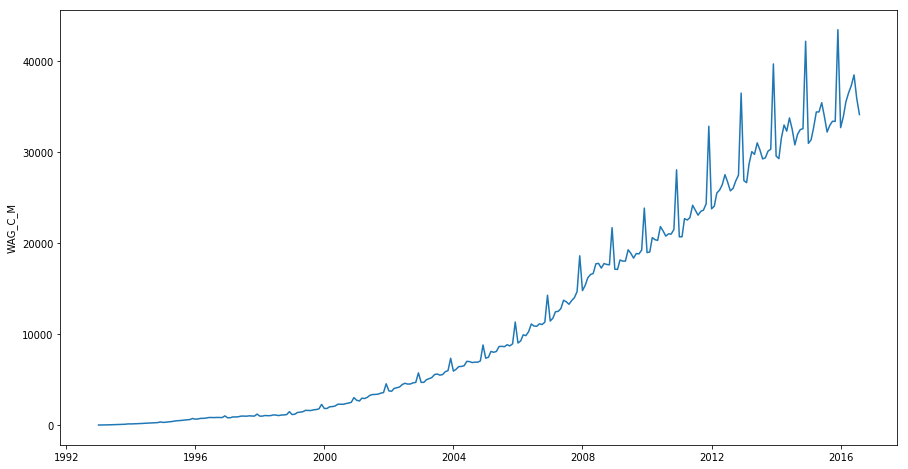

In [4]:
# Построим исходный ряд
plt.figure(figsize(15,8))
plt.plot(data.index,data.WAG_C_M)
plt.ylabel('WAG_C_M')

На графике видим возрастающий тренд, отсюда сразу следует нестационарность исходного ряда. Также видим сезонность: ближе к концу года наблюдаем скачок вверх резкий и затем в начале следующего года резкий скачок вниз. Наблюдается и разброс дисперсии - разброс скачков ряда в начале меньше, чем в конце.

Убедимся в отсутствии стационарности, используя критерий Дики-Фуллера:

In [5]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.991850


p_value>0.05, поэтому на этом уровне доверия не отвергается гипотеза о нестационарности

Проведем STL-декомпозиция ряда:

<Figure size 1080x720 with 0 Axes>

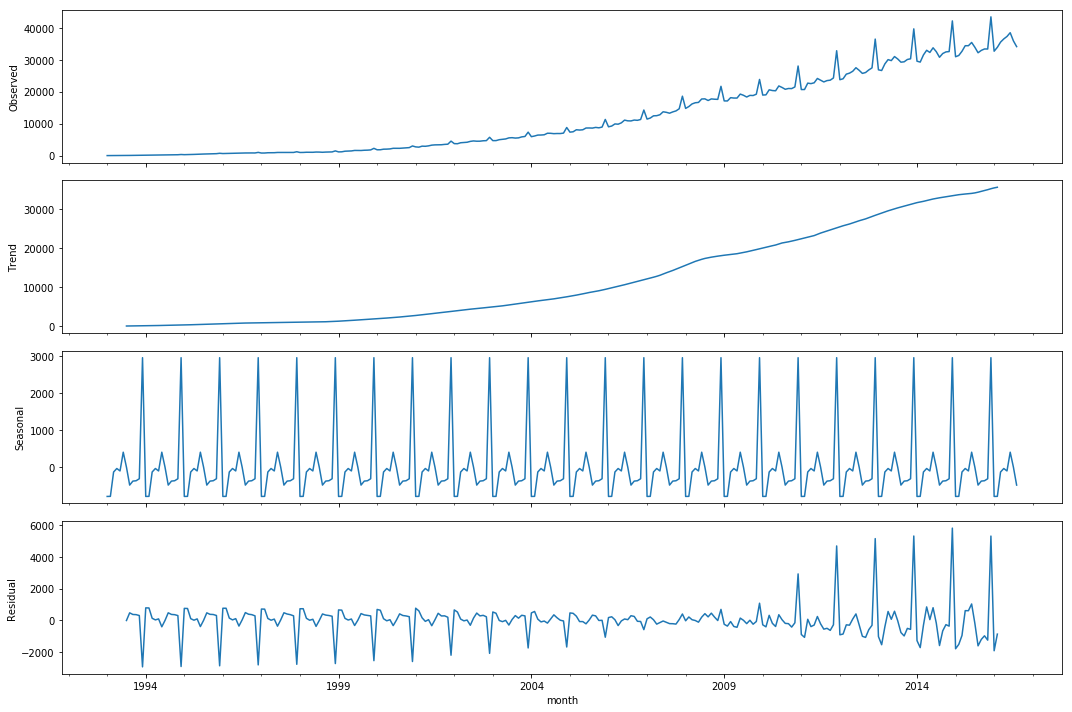

In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot();

Убеждаемся в повышающемся тренед и выраженной сезонности. Остатки не выглядят стационарными - к концу ряда видим повышающийся размах колебаний.

Так как исходный ряд нестационарный, применим преобразование Бокса-Кокса, чтобы стабилизировать дисперсию.

In [7]:
data['zarplata_box'], lmbda = stats.boxcox(data.WAG_C_M)

Text(0, 0.5, 'Transformed WAG_C_M')

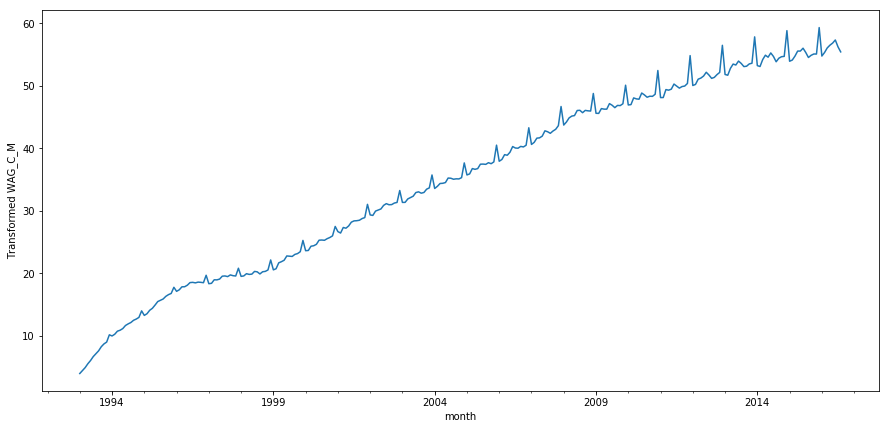

In [8]:
plt.figure(figsize(15,7))
data['zarplata_box'].plot()
plt.ylabel(u'Transformed WAG_C_M')

In [9]:
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['zarplata_box'])[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Попробуем провести сезонное дифференцирование.

Критерий Дики-Фуллера после сезонного дифференцирования: p=0.014697


<Figure size 1080x504 with 0 Axes>

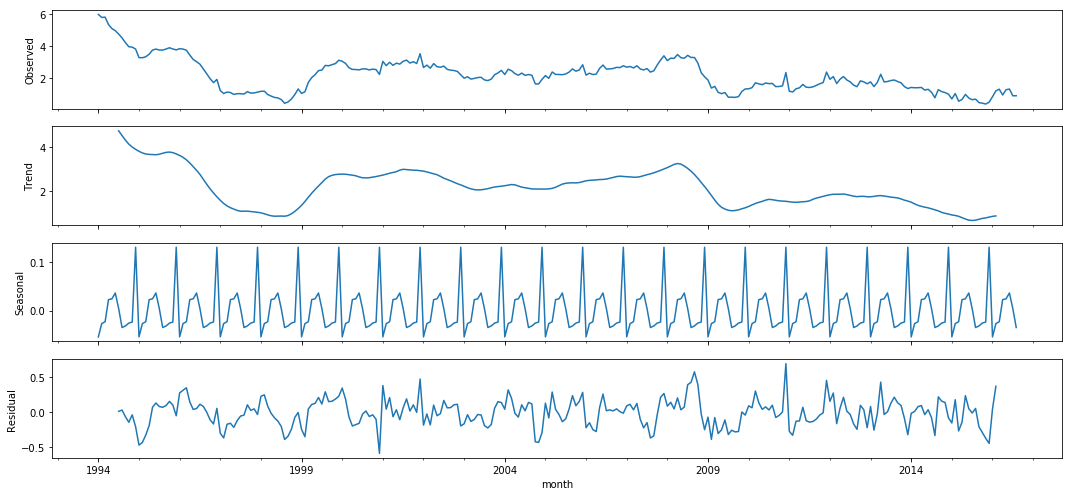

In [10]:
# сезонность у нас год
data['zarplata_shift12']=data.zarplata_box-data.zarplata_box.shift(12)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(data['zarplata_shift12'][12:]).plot();
print("Критерий Дики-Фуллера после сезонного дифференцирования: p=%f" % sm.tsa.stattools.adfuller(data['zarplata_shift12'][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу о нестационарности.Однако не удалось полностью избавиться от тренда в новых данных. Поэтому попробуем применить обычное дифференцирование.

Критерий Дики-Фуллера после обычного дифференцирования: p=0.000000


<Figure size 1080x504 with 0 Axes>

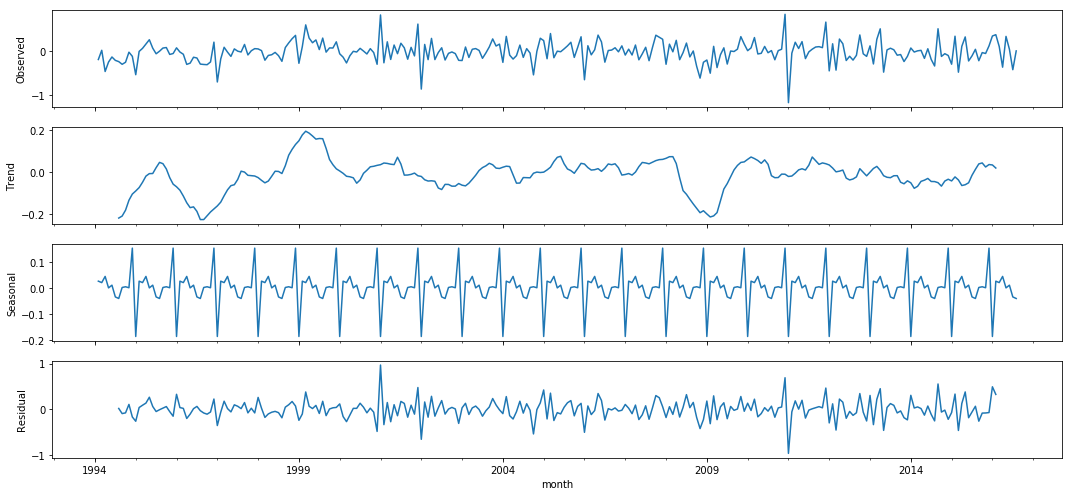

In [11]:
data['zarplata_shift1']=data.zarplata_shift12-data.zarplata_shift12.shift(1)
plt.figure(figsize(15,7))
sm.tsa.seasonal_decompose(data.zarplata_shift1[13:]).plot();
print("Критерий Дики-Фуллера после обычного дифференцирования: p=%f" % sm.tsa.stattools.adfuller(data['zarplata_shift1'][13:])[1])

Критерий Дики-Фуллера отвергает гипотезу о нестационарности. Тренд в новых данных не особо прослеживается. Можно строить модель.

Посмотрим на ACF и PACF полученного ряда:

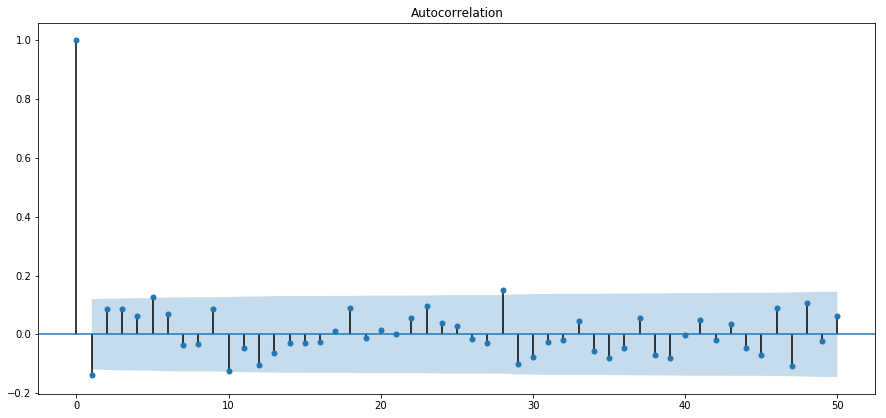

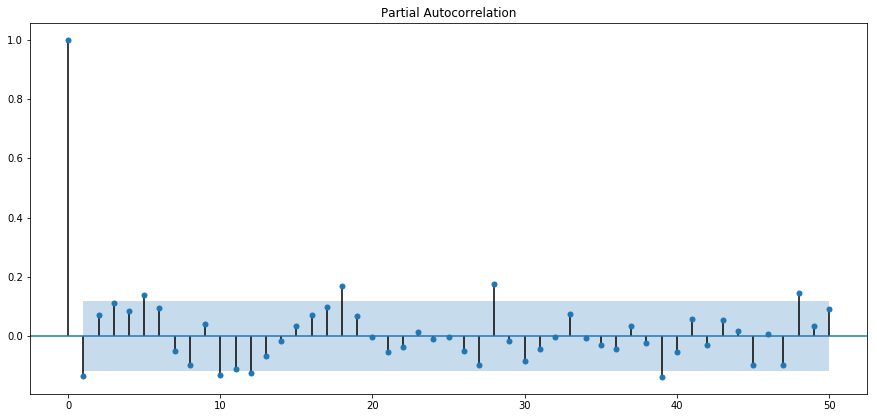

In [12]:
plt.figure(figsize(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.zarplata_shift1[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.zarplata_shift1[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Исходя из графиков и сезонного лага=12 выбираем следующие начальные приближения: Q=0, q=1, P=4, p=10

d=D=1, так как применили только одно обычное и одно сезонное дифференцирование

In [13]:
ps = range(0, 11)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = 0

In [14]:
from itertools import product

In [15]:
# задаем комбинации параметров для раздичных моделей
parameters = product(ps, qs, Ps)
parameters_list = list(parameters)
len(parameters_list)

110

In [17]:
%%time
# строим модели
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['zarplata_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, Qs, 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (2, 1, 0)
wrong parameters: (2, 1, 1)
wrong parameters: (2, 1, 2)
wrong parameters: (2, 1, 3)
wrong parameters: (2, 1, 4)
Wall time: 3min 24s


In [18]:
# смотрим на 5 наилучших моделей
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
56    (6, 0, 1) -7.552970
101  (10, 1, 1) -7.168053
57    (6, 0, 2) -6.480323
59    (6, 0, 4) -6.327815
100  (10, 1, 0) -5.958380


In [19]:
# наилучшая модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       zarplata_box   No. Observations:                  284
Model:             SARIMAX(6, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  11.776
Date:                            Sun, 07 Apr 2019   AIC                             -7.553
Time:                                    11:03:30   BIC                             21.264
Sample:                                01-01-1993   HQIC                             4.017
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1991      0.045     -4.401      0.000      -0.288      -0.110
ar.L2          0.0224      0.066   

Наилучшая модель SARIMA(6, 1, 0)x(1, 1, 0)

Посмотрим на получившиеся остатки

Критерий Стьюдента: p=0.293145
Критерий Дики-Фуллера: p=0.000000


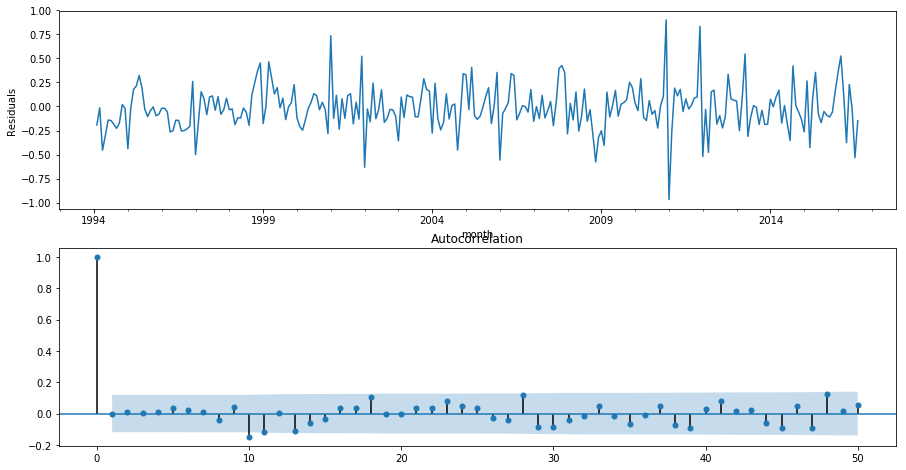

In [20]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) и стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы, что подтверждается коррелограммой и критерием Льюнга-Бокса (из таблицы выше смотрим величину Prob(Q) этого критерия, и она больше alpha=0.05, то есть не отклоняется гипотеза о том, что остатки являютя "белым шумом"). Поэтому можем считать, что наша модель оптимальна.

Посмотрим насколько хорошо наша модель описывает исходный ряд. Для этого необходимо будет провести обратное преобразование Бокса-Кокса.

In [21]:
#обратное преобразование Бокса-Кокса
def invbox_koks(y,lmbda):
    if lmbda==0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

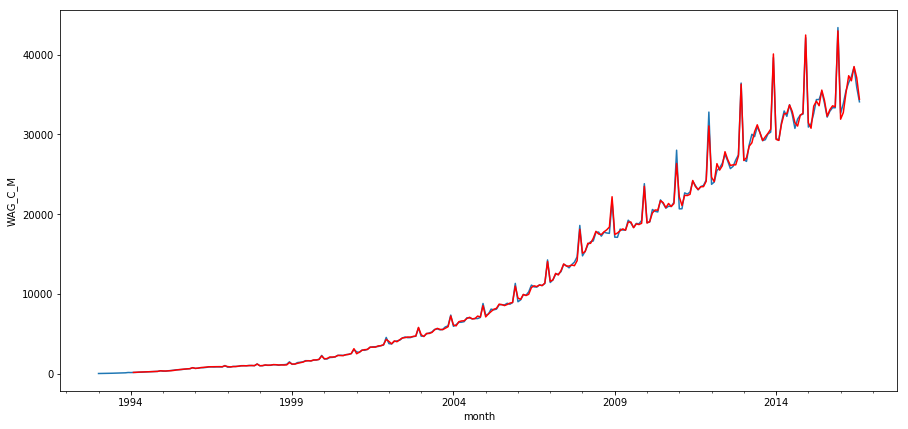

In [22]:
data['model'] = invbox_koks(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

Модель довольно хорошо описывает ряд. Теперь спрогнозируем при помощи построенный модели ряд на два года вперед.

In [23]:
posl_date=data.index[-1] #находим последнюю дату в имеющемся ряде, от нее прогнозируем на два года вперед
date_list = [posl_date + relativedelta(months=x) for x in range(1,25)]

In [24]:
# считаем прогноз
data1=data[['WAG_C_M']]
future=pd.DataFrame(index=date_list,columns=data1.columns)
prognoz=pd.concat([data1,future])
prognoz['forecast']=invbox_koks(best_model.predict(start=len(data.index), end=len(prognoz.index)),lmbda)

Text(0, 0.5, 'WAG_C_M')

<Figure size 1080x576 with 0 Axes>

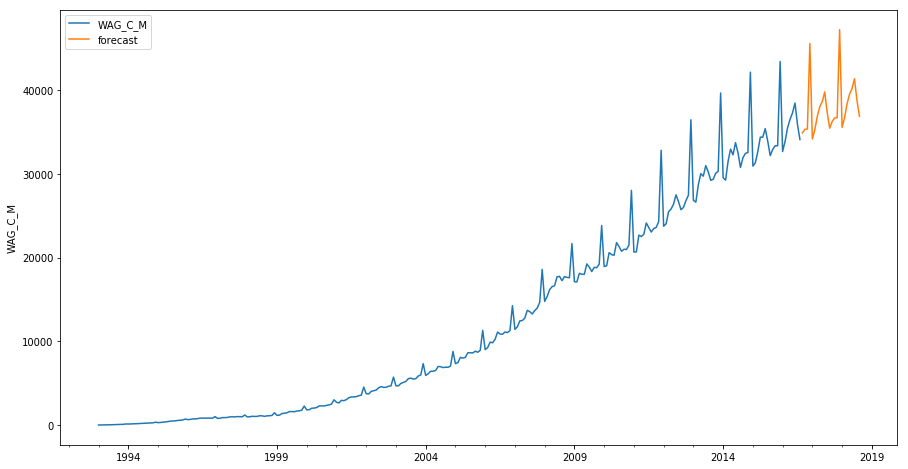

In [25]:
# рисуем график
plt.figure(figsize(15,8))
prognoz.plot()
plt.ylabel('WAG_C_M')

На графике видно, что спрогнозированные значения выглядят адекватно.